In [1]:
import math,datetime
import netCDF4 as nc
import numpy as np 
import tifffile as tiff
import matplotlib.pyplot as plt
import matplotlib.colors as colors

## 1. Prepare the input data

In [2]:
forcing = nc.Dataset("forcing2014.nc")
albedo = nc.Dataset("albedo_2014.nc")
wind = nc.Dataset("wind_2014.nc")
et = nc.Dataset("et_act_2014.nc")
Ts_mod = nc.Dataset("lst.nc")

In [3]:
def shortwave_radiation(forcing): #Makkink method
    #input data are from forcing
    temp = np.array(forcing.variables['temperature'][:])
    pet = np.array(forcing.variables['evapotranspiration'][:])
    
    #using the makkink method to calculate downward shortwave radiation
    es = 0.6107 * 10 ** ((7.5 * temp)/(237.3 + temp)) #saturation  water pressure 
    s = ((7.5 * 237.3)/(237.3 + temp) **2) * np.log(10) * es #the slope of saturation water pressure curve
    gamma = 0.0646 + 0.00006 * temp #the psychrometric constant [hPa/C]
    vapor = (2501 - 2.375 * temp) * 1000
    
    rs_in = pet * (1000 * vapor) * (s + gamma) / (0.65 * s) / 1e9
    return rs_in

## 2. Calculating net shortwave radiation

In [4]:
#Net short radiation 
def net_shortwave_radiation():
    alb = np.array(albedo.variables['AL-BB-DH']
    Rs = shortwave_radiation(forcing)
    Rns = (1 - alb) * Rs
    return Rns

In [5]:
alb = np.array(albedo.variables['AL-BB-DH']

In [6]:
alb.shape

(365, 678, 774)

In [7]:
for varname, var in forcing.variables.items():
    print(f"Variable: {varname}")
    print(f"Path: {var.name}")
    print(f"Shape: {var.shape}")
    print(f"Attributes: {var.ncattrs()}")
    print("")

Variable: time
Path: time
Shape: (365,)
Attributes: ['standard_name', 'units', 'calendar', 'axis']

Variable: lon
Path: lon
Shape: (774,)
Attributes: ['axis']

Variable: lat
Path: lat
Shape: (678,)
Attributes: ['axis']

Variable: precipitation
Path: precipitation
Shape: (365, 678, 774)
Attributes: ['_FillValue', 'missing_value']

Variable: temperature
Path: temperature
Shape: (365, 678, 774)
Attributes: ['_FillValue', 'missing_value']

Variable: evapotranspiration
Path: evapotranspiration
Shape: (365, 678, 774)
Attributes: ['_FillValue', 'missing_value']



## 3. Extraterrestrial radiation

In [32]:
def doy_range(start_year, start_month, start_day, end_year, end_month, end_day):
    start_date = datetime.date(start_year, start_month, start_day)
    end_date = datetime.date(end_year, end_month, end_day)
    delta = end_date - start_date
    doy_list = []

    for i in range(delta.days + 1):
        current_date = start_date + datetime.timedelta(days=i)
        doy = current_date.timetuple().tm_yday
        doy_list.append(doy)

    return doy_list

# Example usage
start_year = 2014
start_month = 1
start_day = 1

end_year = 2014
end_month = 12
end_day = 31

doy_list = doy_range(start_year, start_month, start_day, end_year, end_month, end_day)
print(len(doy_list))

365


In [9]:
#Extraterrestrial radiation
def solar_declination(doy):
    days_in_year = 365
    radians = math.sin((math.pi * 2 * doy / days_in_year) - 1.39)
    decl = 0.409 * radians
    return decl


def relative_distance(doy):
    days_in_year = 365
    radians = math.cos(math.pi * 2 * doy/ days_in_year)
    dist = radians * 0.033 + 1  # distance in AU
    return dist


def extraterrestrial_radiation():
    gsc = 118.08 #MJm-2/day 
    lat = np.array(forcing.variables['lat'][:])
    lon = np.array(forcing.variables['lon'][:])
    lat_rad = lat*math.pi/180 
    lat_rad = np.tile(lat_rad, (len(lon), 1)).T
    lat_rad = lat_rad.reshape((1, lat_rad.shape[0], lat_rad.shape[1]))
    dtime = nc.num2date(forcing['time'][:], forcing['time'].units)
    day_of_year = [dt.timetuple().tm_yday for dt in dtime]
    decl = np.array([solar_declination(doy) for doy in day_of_year]).reshape(len(doy_list), 1, 1)
    dist = np.array([relative_distance(doy) for doy in day_of_year])
    sha = np.arccos(np.tan(lat_rad) * np.tan(decl) * -1)
    # a = np.cos(lat_rad) * np.cos(decl) * np.sin(sha)
    # b = sha * np.sin(lat_rad) * np.sin(decl)
    Ra = dist.reshape(365, 1, 1) * gsc / np.pi *( np.cos(lat_rad) * np.cos(decl) * np.sin(sha) + sha * np.sin(lat_rad) * np.sin(decl))
    Ra = Ra[:,::-1]
    
    return Ra

## 4. Net longwave radiation

In [10]:
#Net longwave radiation (upwards is positive)
def net_longwave_radiation():
    T = np.array(forcing.variables['temperature'][:])
    Rs = shortwave_radiation(forcing)
#     Rs = np.array(np.array(radiation['shortwave_radiation'][:,::-1]))
#     Rs = np.array(rad.variables['DSSF'][:]) / 1e6
    Rso = extraterrestrial_radiation() * 0.75
    ea = 0.611 ** (T * 17.27 / (T + 273.3))
    c1 = 0.34 - 0.14 * ea **0.5
    # c2 = 0.1 + 0.9 *(((Rs/Rsa) - 0.25)/0.5)
    c2 = np.maximum(0.3, np.minimum(1, ((np.maximum(0.05, np.minimum(1, Rs / Rso)) * 1.35) - 0.35)))
    sigma = 4.903e-9 # MJK-4m-2day-1 Steffan Boltzmann constant 
    Rnl = (T + 273.15)**4 * sigma * c1 * c2
    return Rnl

## 5. Net radiation

In [11]:
def net_radiation():
    Rnl = net_longwave_radiation()
    Rns = net_shortwave_radiation()
    Rn = Rns - Rnl
    return Rn

## 6. Surface resistance

In [21]:
def wind_speed():
    u = np.array(wind.variables['u10'])
    v = np.array(wind.variables['v10'])
    wind_10m = np.sqrt(u**2 + v**2)
    wind_2m = wind_10m * 4.87 / np.log((67.8 * 10 - 5.42))
    return wind_2m

In [43]:
def aero_conductance():
    wind_u = wind_speed()
    uz = np.maximum(wind_u, 0.5) #the condition of low wind is limited to 0.5 m/s to account bouyancy
    
    h = 2
    f_h = np.log((813/h) - 5.45)
    ku = np.maximum(0.305 / (f_h * (1  + 2.3)) , 0.0043) 
    ga = ku * uz
    ra = 1/ga
    return ra

In [44]:
def surface_temperature():
    i = np.array(et.variables['interception'][:,::-1])
    e = np.array(et.variables['soilevap'][:,::-1])
    t = np.array(et.variables['transpiration'][:,::-1])
    actevap = e + t + i
    ra = aero_conductance()
    Rn = net_radiation() 
    LE = actevap * 2.45
    T = np.array(forcing.variables['temperature'][:]) + 273.15
    H = (Rn - LE) * 1e6 / 86400
    rho_air = 1.293
    cp = 1013
    Ts = (T +(H *ra / (rho_air * cp))) - 273.15
    return Ts

In [45]:
Ts = surface_temperature()

C:\Users\purnamas\AppData\Local\Temp\ipykernel_9648\997877590.py:6: RuntimeWarning: divide by zero encountered in log
  f_h = np.log((813/h) - 5.45)


In [33]:
a = nc.Dataset('sim_ts2014.nc')
Ts = np.array(a.variables['temperature'][:,::-1])

In [34]:
mod_lst = nc.Dataset('2014myd.nc')
lst_mod = np.array(mod_lst.variables['temperature'][:,::-1])

In [35]:
forcing = nc.Dataset("forcing2014.nc")
T = np.array(forcing.variables['temperature'][:])

In [ ]:
T.shape

In [ ]:
norm = colors.TwoSlopeNorm(vmin=-10, vcenter=0, vmax=10)
# norm = MidpointNormalize(vmin=vmin, vmax=vmax, midpoint50)
cmap = 'RdBu_r' 

plt.imshow(diff[240], norm=norm, cmap=cmap)
plt.colorbar()
plt.title('LST simulated')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.savefig('sims-obs.jpg', format='jpg', dpi=1000)
plt.show()

In [ ]:
Ts[0]

In [46]:
Ts = Ts.filled(fill_value=np.nan)

In [36]:
a = nc.Dataset('sim_ts2014.nc')
Ts = np.array(a.variables['temperature'][:,::-1])

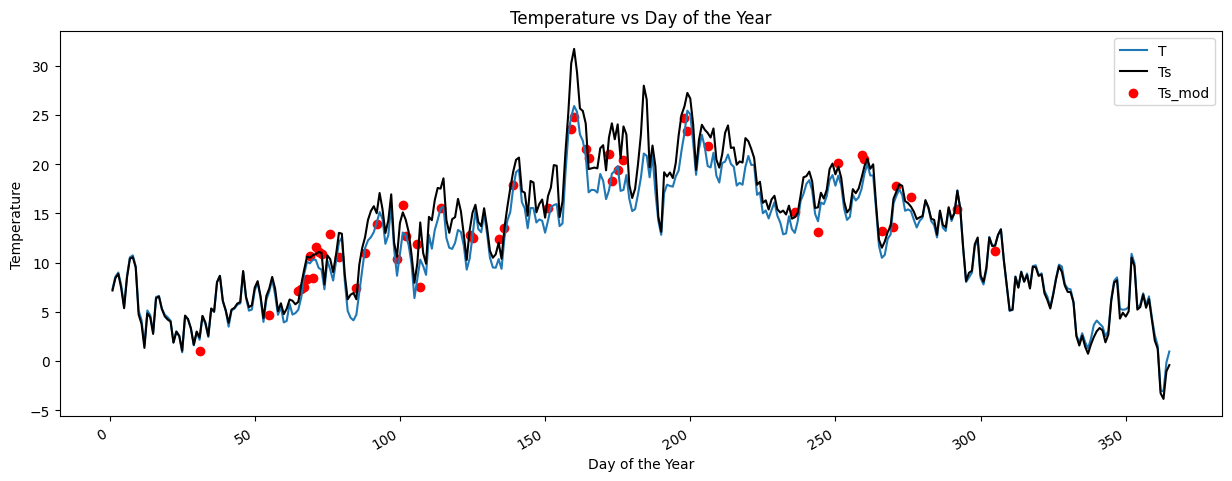

In [37]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import numpy as np

# Assuming doy_list is a list of day of the year values
doy_list = doy_list

# Assuming T is a 2D array, and you want to plot the temperature at a specific location (300, 400)
temperature_at_location = T[:,350, 100]

# Assuming Ts is another 2D array, and you want to plot the surface temperature at the same location
surface_temperature_at_location = Ts[:,350, 100]

mod_lst_at_location = lst_mod[:, 350, 100]

plt.figure(figsize=(15, 5))

# Plotting the timeseries graph for T
plt.plot(doy_list, temperature_at_location, label='T')

# Plotting the timeseries graph for Ts
plt.plot(doy_list, surface_temperature_at_location, label='Ts', color="black")

# Plotting the timeseries graph for Ts mod
plt.scatter(doy_list, mod_lst_at_location, label='Ts_mod', color ='red')

# Giving title to the graph
plt.title('Temperature vs Day of the Year')

# Rotating the x-axis tick labels at 30 degrees towards the right
plt.xticks(rotation=30, ha='right')

# Giving x and y label to the graph
plt.xlabel('Day of the Year')
plt.ylabel('Temperature')

# Adding a legend to distinguish between T and Ts
plt.legend()

# Display the plot
plt.show()


In [ ]:
# saved_lst = nc.Dataset('wflow_ts_2019.nc')
# lst_saved = np.array(saved_lst.variables['temperature'][:,::-1])

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import numpy as np

# Assuming doy_list is a list of day of the year values
doy_list = doy_list

# Assuming T is a 2D array, and you want to plot the temperature at a specific location (300, 400)
temperature_at_location = diff[:,350, 100]

plt.figure(figsize=(15, 5))

# Plotting the timeseries graph for T
plt.scatter(doy_list, temperature_at_location, label='T')

# Giving title to the graph
plt.title('Temperature vs Day of the Year')

# Rotating the x-axis tick labels at 30 degrees towards the right
plt.xticks(rotation=30, ha='right')

# Giving x and y label to the graph
plt.xlabel('Day of the Year')
plt.ylabel('Temperature')

# Adding a legend to distinguish between T and Ts
plt.legend()

# Display the plot
plt.show()


In [47]:
import numpy as np
import datetime
import netCDF4 as nc
from netCDF4 import Dataset, num2date, date2num

nyears = 1
ndays = nyears * 365 # Assuming 365 days in a year
unout = 'days since 2011-01-01 00:00:00'

ny, nx = (678, 774)
lon = np.linspace(5.42917, 11.8708, nx)
lat = np.linspace(46.3292, 51.9708, ny)
# lat = lat[::-1]


dataout = Ts[:,::-1] #correct inverse without changing the data

# Handle NaN values in the dataout array
dataout[np.isnan(dataout)] = np.nan

# dataout = np.array(dict_out['Surface temperature']['values'])  # data yang mau dibuat netcdf
datesout = [datetime.datetime(2014, 1, 1) + datetime.timedelta(days=i) for i in range(ndays)]  # create date values

ncout = Dataset('sim_t2014.nc', 'w', 'NETCDF3')  # using netCDF3 for output format
ncout.createDimension('lon', nx)
ncout.createDimension('lat', ny)
ncout.createDimension('time', None)  # Unlimited dimension for time

lonvar = ncout.createVariable('lon', 'float32', ('lon'))
lonvar[:] = lon
latvar = ncout.createVariable('lat', 'float32', ('lat'))
latvar[:] = lat
timevar = ncout.createVariable('time', 'float64', ('time'))
timevar.setncattr('units', unout)
timevar[:] = date2num(datesout, unout)


myvar = ncout.createVariable('temperature', 'float32', ('time', 'lat', 'lon'))
myvar.setncattr('units', 'Celcius')
myvar[:] = dataout

ncout.close()

In [ ]:
actevap = np.array(et_act.variables['actevap'][:,::-1])
Ts_masked = ma.masked_where(actevap == 0, Ts)

num = len(Ts_masked)
Ts_masked2 = []  # Store results for each iteration

for i in range(num):
    masked = ma.masked_where(landuse_masked <= 142, Ts_masked[i])
    Ts_masked2.append(masked)



Ts_daily = np.array(Ts_masked2)
print(Ts_daily.shape)

# urban_mask = (landuse <= 142)